In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id, udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import schemas
import tools

# 1.Methods
## load

In [2]:
def load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def load_parquet_from_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    # return sqlContext.read.schema(schema).csv(path, sep=";", header=True, schema=schema) if schema is not None else sqlContext.read.schema(schema).csv(path, sep=";", header=True)
    return sqlContext.read.csv(path, sep=";", header=True, schema=schema)


## UDF

In [3]:
def udf_by_grid(df:pd.DataFrame, type = FloatType()):
    return udf(lambda g, t: list(df[df['TIME'] == t[:14]+"00:00"][g])[0], type)

def udf_by_ws():
    schema = StructType([
        StructField("u_interp", FloatType(), True),
        StructField("v_interp", FloatType(), True)
    ])
    return udf(lambda s1, d1, s2, d2, z: tools.wind_interp(s1, d1, s2, d2, z), schema)

def udf_by_tmp():
    schema = StructType([
        StructField("tmp_interp", FloatType(), True),
    ])
    return udf(lambda t1, t2, z: tools.tmp_interp(t1, t2, z), schema)

In [4]:
def udf_regist():
    udf_type = udf(lambda x: {"H": 1.0, "W": 2.0, "P": 3.0, "M": 4.0}.get(x, 0.0), FloatType())
    udf_placement = udf(lambda x: {"LAND": 1.0, "HAV": 2.0}.get(x, 0.0), FloatType())

    udf_hour = udf(lambda x: int(x[11:13]), IntegerType())
    udf_ws10  = udf_by_grid(ws10_dic, FloatType())
    udf_ws100  = udf_by_grid(ws100_dic, FloatType())
    udf_wd10  = udf_by_grid(wd10_dic, IntegerType())
    udf_wd100  = udf_by_grid(wd100_dic, IntegerType())
    # udf_tmp2  = udf_by_grid(tmp2_dic, IntegerType())
    # udf_tmp100  = udf_by_grid(tmp100_dic, IntegerType())
    udf_ws_interp  = udf_by_ws()
    # udf_tmp_interp  = udf_by_tmp()
    return udf_type, udf_placement,udf_hour, udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp

## Aggregate

In [5]:
import pyspark.sql.functions as sf
def aggregate(df, join_df):
    df = df.join(join_df, on="GSRN") \
        .groupBy(df.TIME_CET, join_df.grid) \
        .agg(sf.first(df.GSRN).alias("GSRN"), sf.sum(df.VAERDI).alias("VAERDI"), sf.avg(join_df.Navhub_height).alias("Navhub_height")) \
                    .select("GSRN", "TIME_CET", "VAERDI", "Navhub_height", "grid")

    df = df.withColumn("hour", udf_hour(df.TIME_CET)) \
                .withColumn("ws10", udf_ws10(df.grid, df.TIME_CET)) \
                .withColumn("ws100", udf_ws100(df.grid, df.TIME_CET)) \
                .withColumn("wd10", udf_wd10(df.grid, df.TIME_CET)) \
                .withColumn("wd100", udf_wd100(df.grid, df.TIME_CET))

                # .withColumn("tmp2", udf_tmp2(df.grid, df.TIME_CET)) \
                # .withColumn("tmp100", udf_tmp100(df.grid, df.TIME_CET))
    return df

# def aggregate_with_interp(df, join_df):
#     df = aggregate(df, join_df)
#     df = df.withColumn("wsCol", \
#                 udf_ws_interp(df.ws10, df.wd10, df.ws100, df.wd100, df.Navhub_height)) \
#         .withColumn("tmpCol", \
#         udf_tmp_interp(df.tmp2, df.tmp100, df.Navhub_height)) \
#                 .select("GSRN", "TIME_CET", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "VAERDI", "wsCol.u_interp", "wsCol.v_interp", "tmpCol.tmp_interp")
#     return df

def aggregate_with_interp(df, join_df):
    df = aggregate(df, join_df)
    df = df.withColumn("wsCol", \
                udf_ws_interp(df.ws10, df.wd10, df.ws100, df.wd100, df.Navhub_height)) \
                .select("GSRN", "TIME_CET", "hour", "VAERDI", "wsCol.u_interp", "wsCol.v_interp", "grid")
    return df

# 2.Data Preprocessing

In [6]:
# initialise sparkContext\
spark = SparkSession.builder \
    .master("local") \
    .appName("WindTurbine") \
    .config("spark.executor.memory", "8gb") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

## Settlement

In [7]:
 # to read parquet file
settlement = load_parquet("data/ITU_DATA/settlement/2019.parquet", schemas.settlement_schema)
settlement = settlement.dropna(subset =["VAERDI"]) \
            .withColumn("VAERDI", settlement["VAERDI"].cast("float"))
settlement.persist()

DataFrame[GSRN: string, VAERDI: float, TIME_CET: string]

In [8]:
settlement.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- VAERDI: float (nullable = true)
 |-- TIME_CET: string (nullable = true)



## Weather
from ENetNEA

In [9]:
ws10_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet")
ws100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_100m.parquet")
wd10_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet")
wd100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_100m.parquet")
# tmp2_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/temperatur_2m.parquet")
# tmp100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/temperatur_100m.parquet")

In [10]:
udf_type, udf_placement, udf_hour, udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp = udf_regist()

## Windmills

In [11]:
windmill = load_csv("data/windmill_cleaned.csv", schemas.windmills_schema).sample(fraction=0.4, seed=3)
windmill = windmill.where("grid != 0") \
            .fillna(0.1)
windmill.persist()

DataFrame[GSRN: string, Turbine_type: string, Parent_GSRN: string, BBR_municipal: string, Placement: string, UTM_x: string, UTM_y: string, Capacity_kw: float, Rotor_diameter: float, Navhub_height: float, grid: string, grid_in_range: string]

In [12]:
windmill.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- Turbine_type: string (nullable = true)
 |-- Parent_GSRN: string (nullable = true)
 |-- BBR_municipal: string (nullable = true)
 |-- Placement: string (nullable = true)
 |-- UTM_x: string (nullable = true)
 |-- UTM_y: string (nullable = true)
 |-- Capacity_kw: float (nullable = false)
 |-- Rotor_diameter: float (nullable = false)
 |-- Navhub_height: float (nullable = false)
 |-- grid: string (nullable = true)
 |-- grid_in_range: string (nullable = true)



# 3.ML Analysis

## Clustering with Weather

In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [14]:
train = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET not like '2019-12-30 23%'").sample(fraction=0.0001, seed=5)
test = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET like '2019-12-30 23%'")

In [15]:
train = aggregate_with_interp(train, windmill)
test = aggregate_with_interp(test, windmill)

In [ ]:
train.count()

In [ ]:
test.count()

In [ ]:
ttt = train.select("grid", "TIME_CET").toPandas()

In [ ]:
for i in range(10673):
    try:
        list(ws10_dic[ws10_dic['TIME'] == ttt.loc[i]['TIME_CET'][:14]+"00:00"][ttt.loc[i]['grid']])[0]
    except:
        print(ttt.loc[i]['TIME_CET'],ttt.loc[i]['grid'])
        continue
        

In [ ]:
ttt

In [16]:
feat_cols = ["hour", "u_interp", "v_interp"]
vec_assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
train = vec_assembler.transform(train).select("GSRN","TIME_CET", "features", "VAERDI")
test = vec_assembler.transform(test).select("GSRN","TIME_CET", "features", "VAERDI")

In [17]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train)
train = scalerModel.transform(train)
test = scalerModel.transform(test)
train.persist()
test.persist()

DataFrame[GSRN: string, TIME_CET: string, features: vector, VAERDI: double, scaledFeatures: vector]

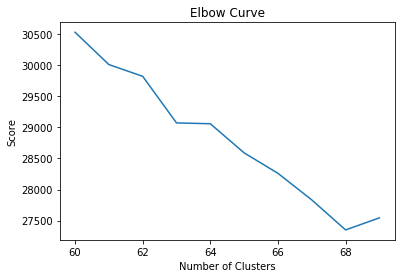

In [19]:
cost = []
clusters = []

for k in range(60, 70):
    kmeans = KMeans(featuresCol='features',k=k, seed=1)
    model = kmeans.fit(train)
    cost.append(model.computeCost(train))
    clusters.append(k)

# Plot the cost
df_cost = pd.DataFrame(cost)
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', clusters)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

optimal k = 68

In [20]:
kmean = KMeans(featuresCol='scaledFeatures', k=68, seed=1)
model = kmean.fit(train)

In [21]:
pred_avg = model.transform(train).where("VAERDI != 0.0").groupBy("prediction").avg("VAERDI")
pred_avg = pred_avg.withColumn("avg(VAERDI)", pred_avg["avg(VAERDI)"].cast("float")).select("prediction", "avg(VAERDI)")
pred_test = model.transform(test).select("GSRN","TIME_CET","prediction", "VAERDI")

In [22]:
import pyspark.sql.functions as sf
result = pred_test.join(pred_avg, on="prediction") \
        .groupby("TIME_CET") \
        .agg(sf.sum("avg(VAERDI)").alias("predicted"), sf.sum("VAERDI").alias("truth")) \
        .orderBy("TIME_CET")

In [23]:
error = udf(lambda x,y : x-y, FloatType())
result.withColumn("error", error(result.truth, result.predicted)) \
        .select("TIME_CET","predicted","truth","error").collect()

[Row(TIME_CET='2019-12-30 23:00:00', predicted=37881.73253250122, truth=590410.7612758875, error=552529.0),
 Row(TIME_CET='2019-12-30 23:15:00', predicted=28182.228031158447, truth=396716.06737193465, error=368533.84375),
 Row(TIME_CET='2019-12-30 23:30:00', predicted=28182.228031158447, truth=395148.8601896763, error=366966.625),
 Row(TIME_CET='2019-12-30 23:45:00', predicted=28182.228031158447, truth=395086.037746042, error=366903.8125)]

In [24]:
data = result.toPandas()

In [ ]:
data.head()

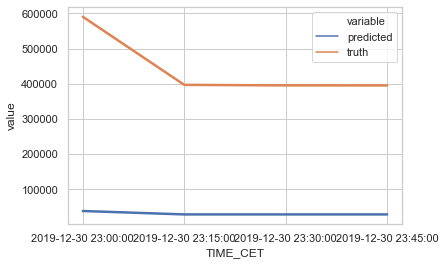

In [25]:
import seaborn as sns
sns.set(style="whitegrid")
sns.lineplot(x="TIME_CET", y="value", data=pd.melt(data, ['TIME_CET']), hue='variable',linewidth=2.5)